# Hankel analytic modelling

This code allows to compare the results from a modelling analytical alternative. The linear solution of the wave equation is solved with two Green functions. Here we replace both green functions with two first order hankel functions. 

$$ \delta_p (s,\mathbf{r},\omega) = -(i \omega)² \ S(\omega) \frac{1}{16} \int   H\left(- \omega  \frac{\mathbf{r}(s,\mathbf{x})}{v_0}\right)  \frac{2\ \delta v(\mathbf{x})}{v_0³} H\left(-\omega  \frac{\mathbf{r}(c,\mathbf{x})}{v_0}\right) d\mathbf{x}$$

Where : 

- $\delta_p (s,r,\omega)$ : is a small perturbation
- $\mathbf{r}$ : is the distance from the source to a spot in the model
- $\mathbf{x}$ : is the spatial position in this case in 2D (x,z)
- $\omega$ : is the angular frequency
- $s$ : is the source position
- $c$ : is the receiver position (channel)
- $v_0$ : is the background velocity (constant in this example)
- $\delta_v = v - v_0$ : is the difference between the perturbation velocity and the background velocity
- $H$ is the first order Hankel function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, exp
from scipy.special import hankel1, hankel2
from tqdm import tqdm
from scipy.signal import hilbert
from wiggle.wiggle import wiggle

# Parameters of the modeling 
There are two sets of parameters that have been tested. The sampling of the grid has been reduced to avoid numerical dispersion on the wavelet. 

We can choose between using sel = 0 or sel = 1

In [2]:
def plot_table(input,title):
    '''Plots 2D tables'''
    plt.figure(figsize=(10,8))
    plt.imshow(input.T, extent=[ax[0], ax[-1], az[-1], az[0]])
    plt.title(title)
    plt.colorbar(label='m/ms')
    plt.ylabel('m')
    plt.xlabel('m')
    plt.show()

In [3]:
def find_nearest(array, value):
    '''Finds the nearest offset value in the numerical solution input'''
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

In [4]:
def readbin(flnam,nz,nx):
    ''' Read binary file (32 bits) '''
    with open(flnam,"rb") as fl:
        im = np.fromfile(fl, dtype=np.float32)
    im = im.reshape(nz,nx,order='F')
    return im

In [5]:
def defwsrc(fmax, dt, lent):
    """
    Definition of the source function
    Ricker wavelet with central frequency fmax/2.5
    Ricker = 2nd-order derivative of a Gaussian function
    """
    fc = fmax / 2.5  # Central frequency
    ns2  = nws + lent # Classical definition
    ns = int((ns2-1)/2)  # Size of the source
    wsrc = np.zeros(ns2)
    for it in range(-ns,ns+1):
        a1 = float(it) * fc * dt * pi
        a2 = a1 ** 2     
        wsrc[it+ns] = (1 - 2 * a2) * exp(-a2)
    if len(wsrc) % 2 == 0 :
        print('The wavelet is even. The wavelet must be odd. \
        There must be the same number of samples on both sides of the maximum value')
    else: 
        print('Wavelet length is odd = ' + str(len(wsrc))+ '. No correction needed' )
        return wsrc

In [6]:
def extend_zeros(tr):
    '''Extend a trace with zeros to match lenght'''
    tr_ext = np.zeros(len(wsrc))
    for i in range(nt):
        tr_ext[i] = tr[i]
    return tr_ext
    

In [7]:
def avoid_zeros(inp,nz):
    '''Finds the indexes from which to start iterating in the model'''
    for i in range(nz):
        if inp[i,301] > 0:
#             print(i)
            break
    for k in range(i,nz):
        if inp[k,301] < 0.01:
#             print(k)
            break
    return i,k

In [79]:
def ray_tracing_tt(dz, v0, ao, start_z,ft):
    ''' Calulates the analytical ray traveltime for a given offset and depth'''
    h1     = dz * start_z
    t0     =  h1 / v0
    t1     = np.sqrt(t0**2 + (ao/v0)**2)+ft
    return t1

In [9]:
""" Parameters [km, s]"""

sel = 0 # Choose between 0 and 1 for a set of parameters, it will read the data according to it.
testno = 27 # name of the output for the parameters units tests

if sel == 0:   # 0 for the parameters below
    dz = 12.
    dx = 12.
    dt = 1.41e-3
elif sel == 3:   # 0 for the parameters below
    dz = 12.
    dx = 12.
    dt = 1.41e-3
elif sel== 1: # 1 for the parameters below 
    dz = 6.
    dx = 6. 
    dt = 0.63e-3   
elif sel== 2: # 1 for the parameters below 
    dz = 3.
    dx = 3. 
    dt = 0.35e-3

do = dx
ft = -100.11e-3
fx = 0.0
fz = 0.0


nx = 601
nz = 151
no = 251
nt = 1501

fo = -(no-1) / 2 * do 


az = fz + np.arange(nz) * dz 
ax = fx + np.arange(nx) * dx 
ao = fo + np.arange(no) * do 
at = ft + np.arange(nt) * dt 

ixsrc = 300 # One value less than in fortran
ixrec = 300 # One value less than in fortran
izsrc = 1   # One value less than in fortran
izrec = 1   # One value less than in fortran


src_x = ixsrc * dx
rec_x = ixrec * dx
src_z = izsrc * dz
rec_z = izrec * dz

off_x = (src_x - rec_x)

In [10]:
# Read the velocity models
fl1 = 'input/inp_flat_2050.dat'
inp1 = readbin(fl1, nz, nx)
# inp1 = readbin(fl1, nz, nx)

fl2 = 'input/inp_const_2000.dat'
inp2 = readbin(fl2, nz, nx)
# inp2 = readbin(fl2, nz, nx)

# Calculate delta_v
inp_flat = (inp1 - inp2)*1000 

""" Parameters for modelling """
v0 = 2000
delta_v_n = (2 * inp_flat.T) / (v0 ** 3) 



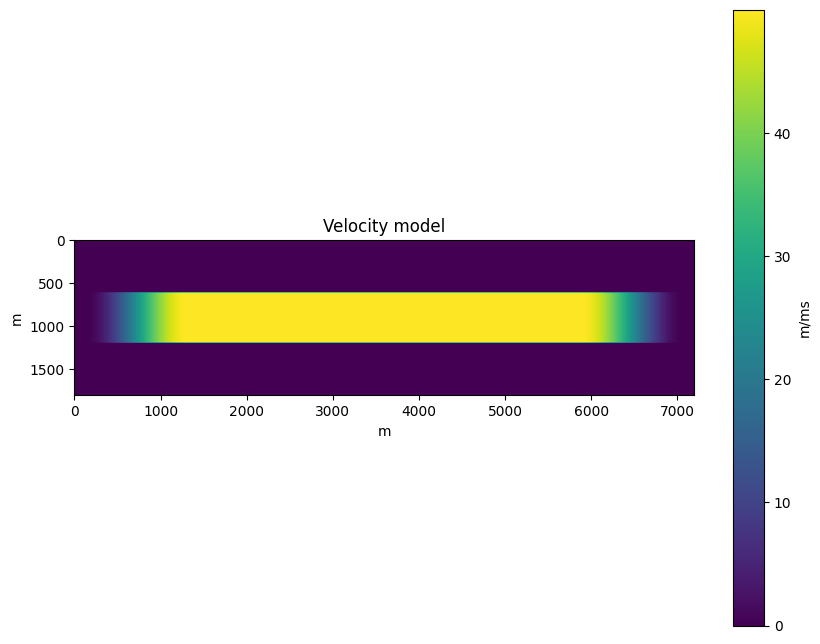

In [11]:
# Plot the input model 
plot_table(inp_flat.T,'Velocity model')

# Definition of the source

In [12]:
# Read the shot gathers from numerical modelling 
# Reads the data according to the parameters
if sel == 0:
    '''for dt = 1.41e-3'''
    fl3 = '../../out_141/t1_obs_000301.dat'
    inp3 = readbin(fl3, no, nt)
    fl = '../../out_141/wsrc.dat'
    nws = 143  
elif sel==3:
    fl3 = '../../out_v0_09/t1_obs_000301.dat'
    inp3 = readbin(fl3, no, nt)
    fl = '../../out_v0_09/wsrc.dat'
    nws = 143 
elif sel==1:
    '''For dt = 0.7e-3 '''
    fl3 = '../../t1_obs_000301.dat'
    inp3 = readbin(fl3, no, nt)
    fl =  'input/dt070_wsrc.dat'
    nws = 287
elif sel==2:
    '''For dt = 0.35e-3 '''
    fl3 = 'input/dt035_t1_obs_000301.dat'
    inp3 = readbin(fl3, no, nt)
    fl =  'input/dt035_wsrc.dat'
    nws = 573
    
    
wsrc_num = readbin(fl, nws, 1)[:, 0] # Wavelet of the numerical solution

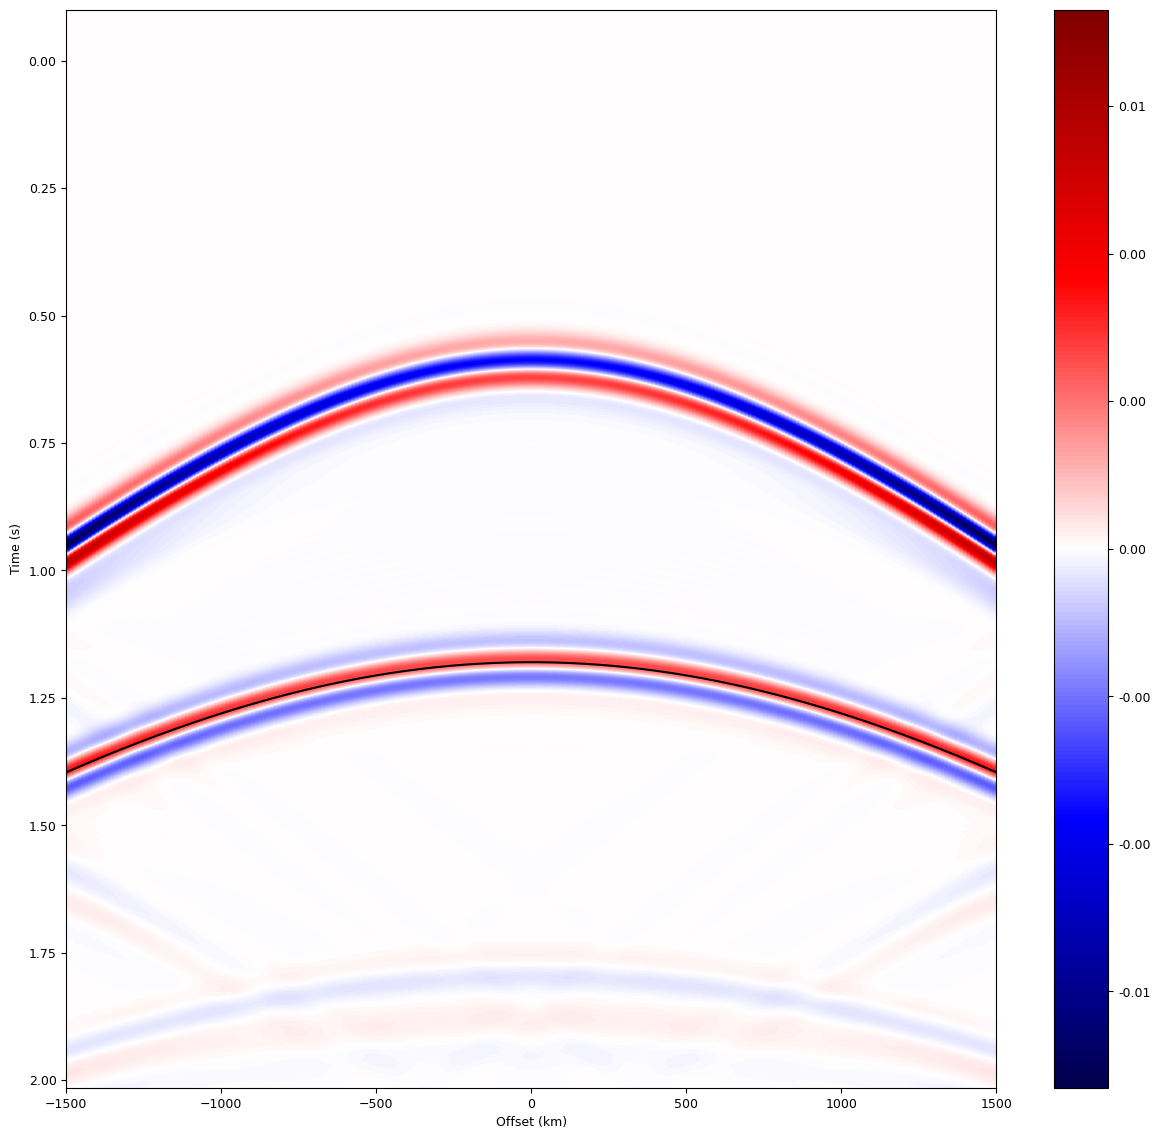

In [110]:
def plot_shot_gathers(hmin, hmax, inp):
    plt.rcParams['font.size'] = 9
    fig = plt.figure(figsize=(15, 14), facecolor="white")
    av = plt.subplot(1, 1, 1)
    hfig = av.imshow(inp, extent=[ao[0], ao[-1], at[-1], at[0]],
                     vmin=hmin, vmax=hmax, aspect='auto',
                     cmap='seismic')
#     wiggle(inp[::5])
    plt.colorbar(hfig, format='%2.2f')
    plt.xlabel('Offset (km)')
    plt.ylabel('Time (s)')

    return fig

hmin = np.min(inp3)
hmax =  -hmin
z1=(end_z+0.5-izsrc)*2 ## The addition of 0.5 is a correction of half a pixel, intended to precisely align with the position of the reflection indicated by the numerical case.
ttr = ray_tracing_tt(dz, v0, ao, z1,0)
fig = plot_shot_gathers(hmin, hmax, inp3.T)
correction= 49*2*12/2000-(2*49*12/2050)
plt.plot(ao,ttr-correction,'-k')

# ray_tt = ray_tracing_tt(dz,v0,ao,start_z)
# plt.plot(ao,ray_tt,'k')

In [14]:
# Parameters of the analytical source wavelet
fmax = 25
nt2 = nt - (nws-1) / 2 
nt_len = int((nt2+1) * 2)
wsrc = defwsrc(fmax, dt, nt_len - nws + 1)  # lengthen wavelet to nt of the numerical solution
wsrc_org = defwsrc(fmax, dt,0) # original wavelet


nf = len(wsrc)
aw2 = 2. * pi * np.fft.fftfreq(nf, dt)

wsrcf = np.fft.fft(wsrc)

diff_wsrc = wsrc_org - wsrc_num

Wavelet length is odd = 2863. No correction needed
Wavelet length is odd = 143. No correction needed


In [15]:
# Select the trace to compare

near_off = find_nearest(ao, off_x)[0]

idx_off = np.where(ao == near_off) # Find the index of the given offset
tr3 = inp3[idx_off][0]  



# Extend the trace to the lenght of the analytical source
tr3_ext = extend_zeros(tr3)
print('length before extension: ',tr3.shape)
print('length after extension: ',tr3_ext.shape)

length before extension:  (1501,)
length after extension:  (2863,)


Text(0.5, 1.0, 'Extension of the trace to the source length')

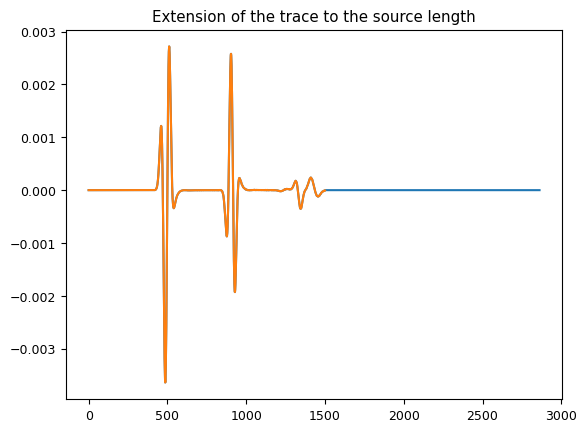

In [16]:
plt.plot(tr3_ext)
plt.plot(tr3)
plt.title("Extension of the trace to the source length")

In [17]:
print('Source length: ',len(wsrc))

Source length:  2863


Text(0.5, 1.0, 'Lengthen of the wavelet')

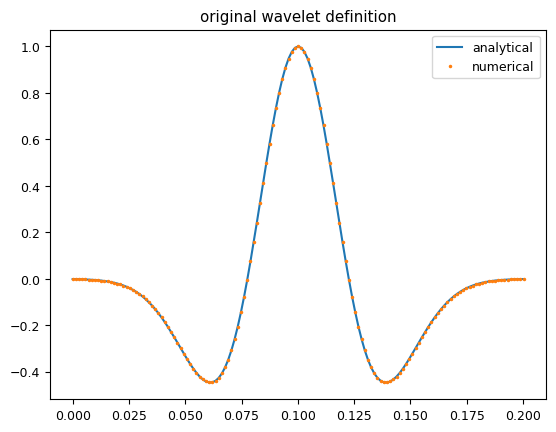

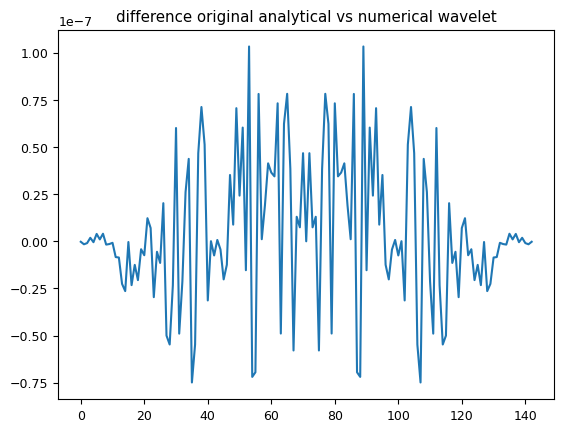

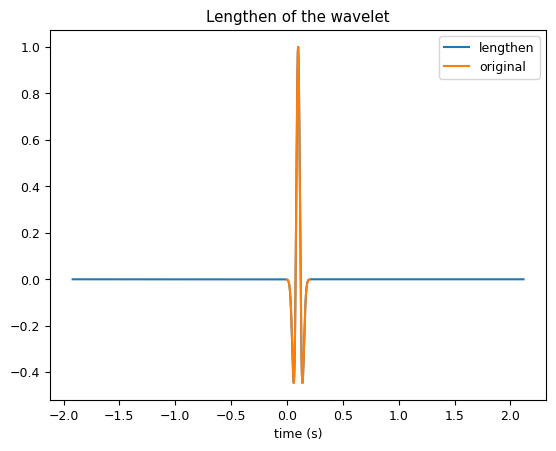

In [45]:
t = np.arange(len(wsrc_org)) * dt
plt.figure()
plt.plot(t, wsrc_org, label = 'analytical')
plt.plot(t, wsrc_num, '.', markersize=3, label = 'numerical')
plt.legend()
plt.title('original wavelet definition')
flout = 'tests/wavelet_test'+str(testno)+'.png'
plt.savefig(flout, bbox_inches='tight')

plt.figure()
plt.plot(diff_wsrc)
plt.title('difference original analytical vs numerical wavelet')


at_wsrc_org = np.arange(len(wsrc_org)) * dt - len(wsrc_org) * dt / 2 -ft
at_wsrc = np.arange(len(wsrc)) * dt - len(wsrc) * dt / 2 -ft
# The wavelet has to be lenghten due to the arrival time higher than the source length
plt.figure()
plt.plot(at_wsrc,wsrc,label = 'lengthen')
plt.plot(at_wsrc_org,wsrc_org,markersize=3,label = 'original')
plt.xlabel('time (s)')
plt.legend()
plt.title('Lengthen of the wavelet')



# Calculation of the distance

Distance between the source and receiver to any point in the model

In [19]:
def distance_to_spot(pos_x, pos_z, nx, nz, dx, dz,ax,az):
    '''Calculates the distance to a given point in the model (spot)'''

    r = np.zeros((nx, nz))
    for i in range(nx):
        r[i,:] = np.sqrt((pos_x - ax[i]) ** 2 + (pos_z - az[:]) ** 2)
    return r

In [20]:
s_p = distance_to_spot(src_x,src_z,nx,nz,dx,dz,ax,az)
p_r = distance_to_spot(rec_x,rec_z,nx,nz,dx,dz,ax,az)

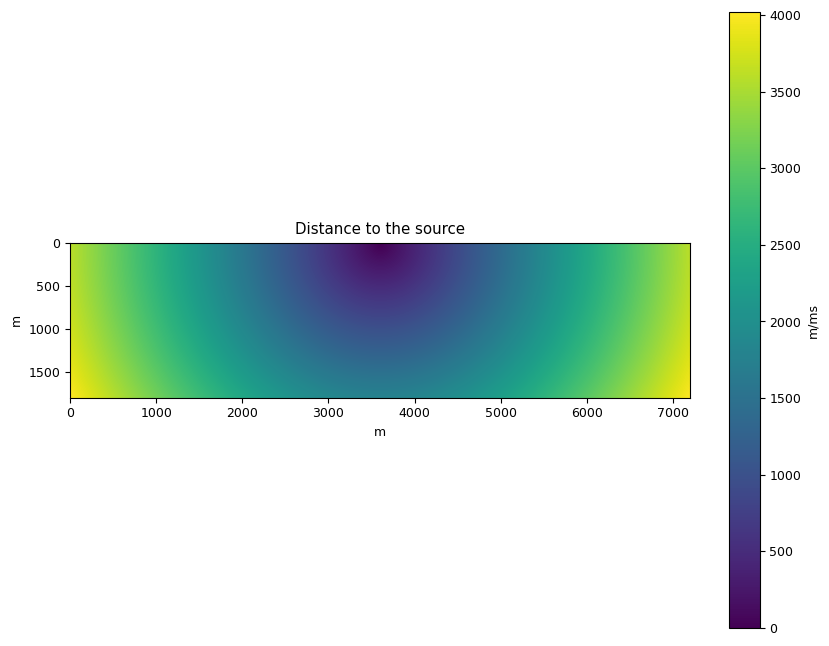

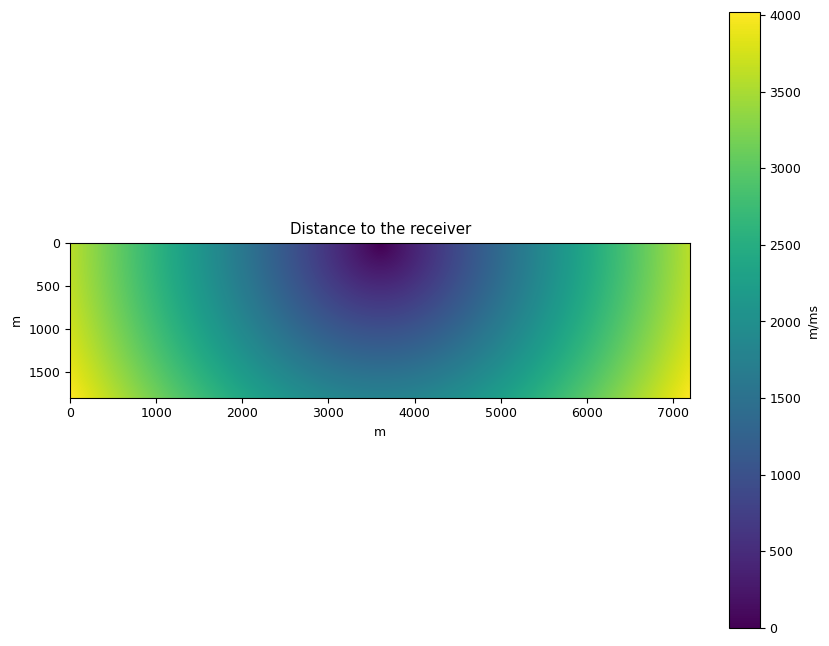

In [21]:
plot_table(s_p,'Distance to the source')
plot_table(p_r,'Distance to the receiver')

# Hankel wave propagation before multiplication
We solve only this part of the integral:
$$ hk =  \int  \left(\frac{i}{4} H\left(-\omega \frac{ \mathbf{r}(s,\mathbf{x})}{v_0}\right)\right)  \frac{2\ \delta v(\mathbf{x})}{v_0³}\left(\frac{i}{4}  H\left(-\omega \frac{\mathbf{r}(c,\mathbf{x})}{v_0}\right) \right)d\mathbf{x}$$

In [22]:
def hankel_wave_prop(d_src, d_rec, delta_v_n, aw, start_z, end_z):
    '''Calculates wave propagation with hankel functions replacing green's functions'''
    hk = np.zeros((nf),dtype='complex')

    for ix in tqdm(range(nx)):
        for iz in range(start_z,end_z):
            hk += (1j / 4. * hankel1(0., d_src[ix, iz] * -aw / v0)) * delta_v_n[ix, iz]\
                    * (1j / 4. * hankel1(0., d_rec[ix, iz] * -aw / v0))
    hk[0] = 0 # Replace nan by zero for $\omega = 0$
#     print(ix,iz)
    return hk

In [23]:
%%time
'''Hankel wave propagation'''
start_z,end_z = avoid_zeros(inp_flat,nz)
hk = hankel_wave_prop(s_p, p_r, delta_v_n, aw2, start_z, end_z)

100%|█████████████████████████████████████████| 601/601 [00:30<00:00, 19.46it/s]

CPU times: user 31 s, sys: 136 ms, total: 31.1 s
Wall time: 30.9 s


# Solution of Hankel wave propagation
The result $hk$ is multiplied by the second derivative and the source term
$$\delta_p (s,r,\omega) = (i \omega)² \ S(\omega) \ hk $$ 

It is possible to not multiply by the second derivative
$$\require{cancel}$$  
$$\delta_p (s,r,\omega) = \cancel{(i \omega)²}  S(\omega) \ hk $$ 


In [24]:
# dp_f = hk * wsrcf * (1j*aw2)**2
# dp_f = hk * wsrcf * (1j*aw2)**3


dp_f = hk * wsrcf * (1j * aw2)**3 * (dx*dz)**2 / (v0 / 2)
                                                            

dp_t = np.real(np.fft.ifft(dp_f))

# Normalization
We need to normalize the data from both results to compare

In [25]:
def normalize(inp):
    """Normalize the data according to its maximum"""
    norm_inp = inp/np.max(abs(inp))
    return inp
#     return norm_inp


In [26]:
dp_t_norm = normalize(dp_t)

# Comparison of the source and the result of the Hankel $\delta_p$

- The result of the Hankel modeling is a shift of the wavelet in time
- This shift is the traveltime of the wave until the first and second reflection

Text(0.5, 1.0, 'Source and hankel result')

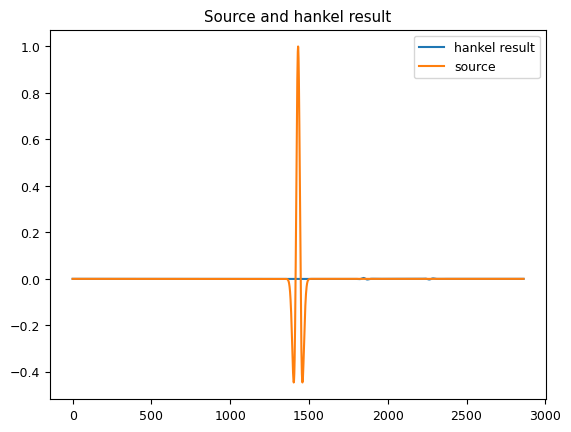

In [27]:
plt.plot(dp_t_norm,label='hankel result')
plt.plot(wsrc,label='source')
plt.legend()
plt.title('Source and hankel result')

In [28]:
print(np.max(dp_t)/np.max(wsrc))

0.0038042598809199983


# Repositionning 
- We need to reposition the result so that the events are on the right of the source maximum
- We shift the wavelet and the result so that the result is according to the wavelet $t=0$

In [29]:
# Find the shift between hankel result and trace

idx_src = int((len(wsrc)-1)/2+1-ft/dt) # non-causal signal
# idx_src = int((len(wsrc)-1)/2+1) # causal signal

dp_t_corr = np.roll(dp_t_norm, idx_src)
wsrc_corr = np.roll(wsrc, idx_src)

In [30]:
# Verify that it is a causal signal, the maximum value is at zero
if wsrc_corr.argmax() == 0 :
    print("Wavelet is causal, the maximum is at zero") 
else :
    print("Warning : wavelet is not causal")
print("Max index = ",wsrc_corr.argmax()) 
print("First index = ",wsrc_corr[0] )

Max index =  71
First index =  -0.0009506206933305965


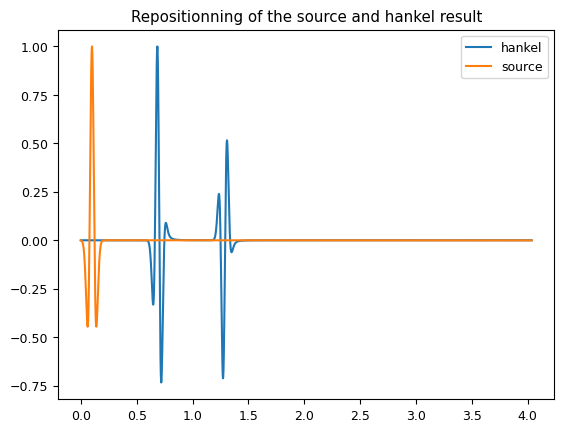

In [51]:
t = np.arange(len(wsrc))*dt # t non causal
# t = np.arange(len(wsrc))*dt # t causal


plt.plot(t,dp_t_corr/np.max(dp_t_corr), label='hankel')
plt.plot(t,wsrc_corr, label='source')
plt.title('Repositionning of the source and hankel result')
plt.legend()
plt.show()

# Comparison 

- We plot the result of the Hankel modeling (analytical) overlaying the numerical solution

0.0


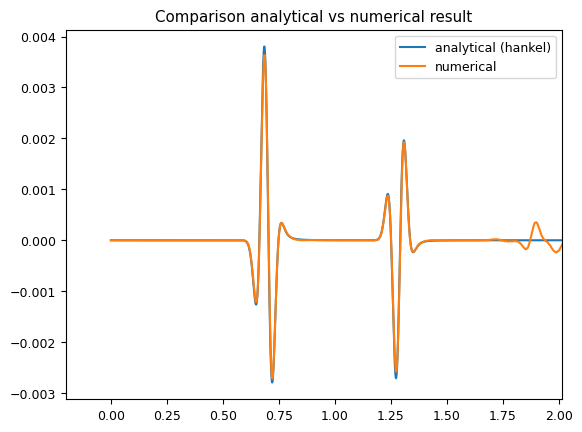

In [53]:
# Compare with the numerical result
tr3_norm = normalize(-tr3_ext) 
# tr3_norm = np.roll(tr3_norm,int(ft/dt)) # Shift numerical trace to start at 0
z1 = 48
ray_tt = 2 * z1 * dz / v0

plt.plot(t,dp_t_corr, label='analytical (hankel)')
plt.plot(t,tr3_norm, label='numerical')
plt.title('Comparison analytical vs numerical result')
plt.scatter(ray_tt,c='k', s=5)
plt.xlim(ft-0.1,at[-1])
# plt.xlim(0.3,0.8)
plt.legend()
print(t[0])

In [54]:
start_z

51

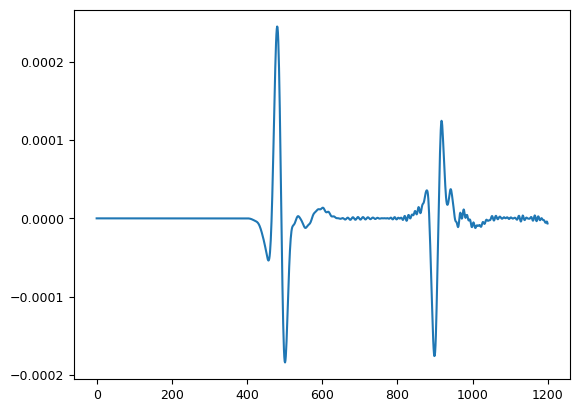

In [33]:
#Calculation of the difference between analytical and numerical result
diff_norm = dp_t_corr[:1200] - tr3_norm[:1200]

plt.plot(diff_norm)


# Calculation of the amplitude ratio


In [34]:
print('Amplitude ratio    = ',  np.max(np.abs(tr3)/np.max(np.abs(dp_t))))
# print('Numerical maximum  = ', np.max(np.abs(tr3)))
# print('Analytical maximum = ', np.max(np.abs(dp_t)))


Amplitude ratio    =  0.9559633


# Phase rotation
Testing if a phase rotation can correct for the differences

In [35]:
def phase_rot(inp,fact):
    """Modification of the phase according to an angle 'fact'"""
    wsrcf = np.fft.rfft(inp,axis=-1)
    n     = len(wsrcf)
    wsrcf *= np.exp(1j*fact)
    mod_ph = np.fft.irfft(wsrcf,axis=-1)
    return mod_ph

In [36]:
# Rotation de phase pi/2
tr_ph90 = phase_rot(dp_t_corr,pi/2)

# Rotation de phase pi/4
tr_ph45 = phase_rot(dp_t_corr,-pi/4)

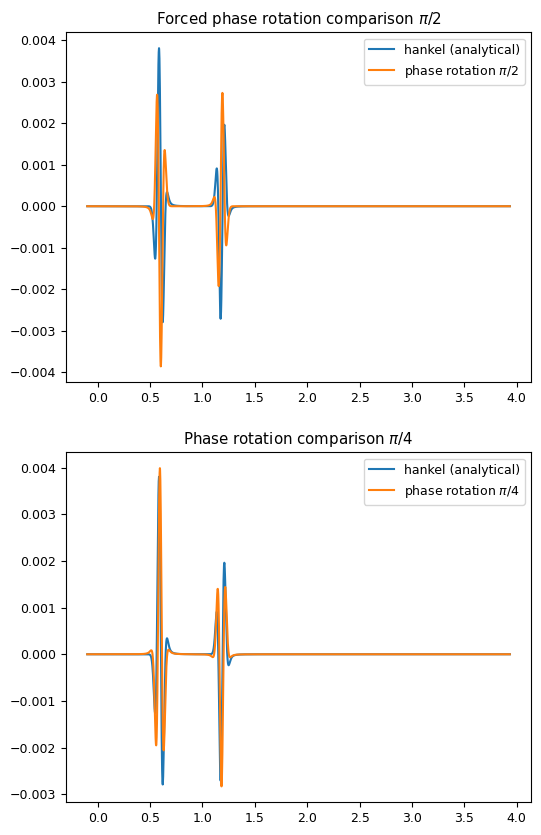

In [37]:
# plt.plot(tr_ph, label='numerical phase rot')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1,
                                    figsize=(6, 10))

# ax1 = plt.subplot(311)
ax1.plot(t,dp_t_corr, label='hankel (analytical)')
ax1.plot(t[:-1],tr_ph90, label='phase rotation $\pi/2$')
ax1.set_title('Forced phase rotation comparison $\pi/2$')
# ax1.set_xlim(0.3,1.5)

ax1.legend()


# plt.plot(tr_ph, label='numerical phase rot')
# ax2 = plt.subplot(312)
ax2.plot(t,dp_t_corr, label='hankel (analytical)')
ax2.plot(t[:-1],tr_ph45, label='phase rotation $\pi/4$')
ax2.set_title('Phase rotation comparison $\pi/4$')
# ax2.set_xlim(0.3,1.5)
ax2.legend()

# Hilbert transform

The hilbert transform produces a phase rotation

In [38]:
def hilbert_transform(inp):
    hilb_new = hilbert(inp)
    hilb_new = hilb_new.imag
    hilb_new = normalize(hilb_new)
    return hilb_new

In [39]:
hb_tr = hilbert_transform(tr3_norm)

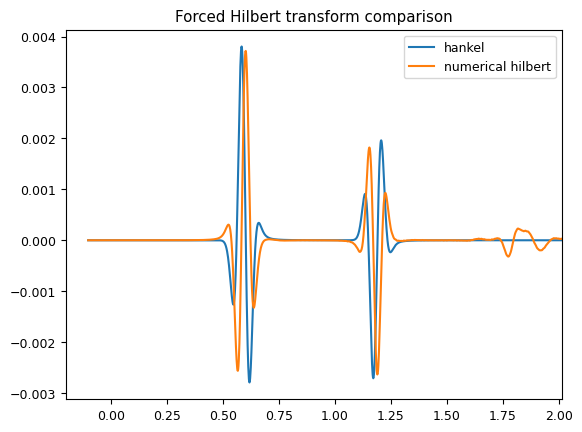

In [40]:
plt.plot(t-dt,dp_t_corr, label='hankel')
plt.plot(t-dt,hb_tr, label='numerical hilbert')
plt.title('Forced Hilbert transform comparison')

plt.xlim(ft-0.1,at[-1])
plt.legend()
plt.show()

# Export listing and test results

In [41]:
tbl_out = 'tests/listing_test'+str(testno)+'.txt'
with open( tbl_out, 'w') as writer:
    writer.write('dt    = '+str(dt) + '\n')
    writer.write('dx    = '+str(dx) + '\n')
    writer.write('dz    = '+str(dz) + '\n')
    writer.write('do    = '+str(do) + '\n\n')

    writer.write('ft    = '+str(ft) + '\n\n')
    writer.write('fx    = '+str(fx) + '\n')
    writer.write('fz    = '+str(fz) + '\n')
    writer.write('fo    = '+str(fo) + '\n')
    
    
    writer.write('nx    = '+str(nx) + '\n')
    writer.write('nz    = '+str(nz) + '\n')
    writer.write('nt    = '+str(nt) + '\n')
    writer.write('no    = '+str(no) + '\n \n')
    
    writer.write('start_z = '+str(start_z) + ' \n')
    writer.write('end_z = '+str(end_z) + '\n \n')
    
    writer.write('src_x = '+str(src_x) + '\n')
    writer.write('rec_x = '+str(rec_x) + '\n')
    writer.write('src_z = '+str(src_z) + '\n')
    writer.write('rec_z = '+str(rec_z) + '\n')
    writer.write('izsrc = '+str(izsrc) + '\n')
    writer.write('izrec = '+str(izrec) + '\n')
    writer.write('off_x = '+str(np.abs(off_x)) + '\n\n')
    
    writer.write('fmax  = '+str(fmax) + '\n')
    writer.write('v_max = '+str(np.max(inp_flat)) + '\n')
    writer.write('v_min = '+str(np.min(inp_flat))  + '\n')
    writer.write('v0    = '+str(v0) + '\n\n')
    
    writer.write('Amplitude ratio = ' + str(np.max(np.abs(tr3)/np.max(np.abs(dp_t) )))+ '\n')
    writer.write('Numerical abs max  = ' + str(np.max(np.abs(tr3))) + '\n')
    writer.write('Analytical abs max = ' + str(np.max(np.abs(dp_t))) + '\n')
 # One value less than in fortran

with open(tbl_out, 'r') as reader:
    list = reader.readlines()

for i in range(len(list)): 
    print(list[i])

dt    = 0.00141

dx    = 12.0

dz    = 12.0

do    = 12.0



ft    = -0.10011



fx    = 0.0

fz    = 0.0

fo    = -1500.0

nx    = 601

nz    = 151

nt    = 1501

no    = 251

 

start_z = 51 

end_z = 100

 

src_x = 3600.0

rec_x = 3600.0

src_z = 12.0

rec_z = 12.0

izsrc = 1

izrec = 1

off_x = 0.0



fmax  = 25

v_max = 49.999954

v_min = 0.0

v0    = 2000



Amplitude ratio = 0.9559633

Numerical abs max  = 0.003636733

Analytical abs max = 0.0038042598809199983



# Comparing to analytical raytracing

- The first test evaluates the travel time at zero-offset for raytracing and the analytical hankel modeling
- Zero offset formula is $\frac{2z}{v} $ where $z$ is the depth of the interface and $v$ the velocity of the first layer
- We verify first the exact depth of the interface that is in between two pixels in the model

51
index for the reflexion =  101.0



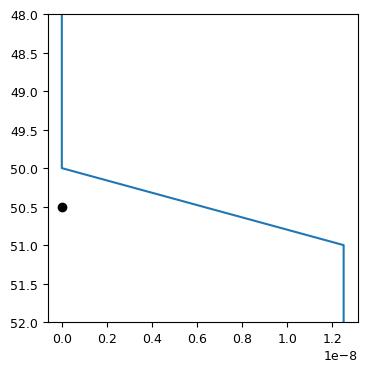

In [113]:
# Displays the interface position in model indexes
plt.figure(figsize=(4,4))

pos_int = (start_z+0.5-izsrc)*2 
# pos_int = (end_z+0.5-izsrc)*2
print(start_z)

plt.plot(delta_v_n.T[:,301],az/dz)
# plt.plot(delta_v_n.T[:,301],az)
plt.scatter(0,pos_int/2,color='k')
plt.ylim(52,48)
print('index for the reflexion = ',pos_int)
print()

0.606


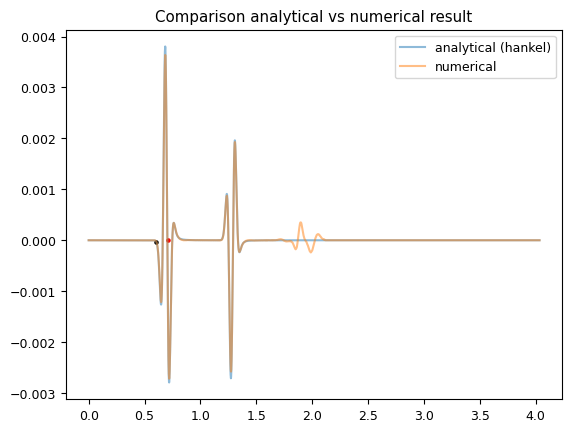

In [115]:
# In the raytracing calculation we substract 2 pixels to correct for the depth of the source and receiver
# We substract half a pixel to be more precise on the position of the interface
z1 = pos_int


ray_tt =  z1 * dz / v0
ray_tt = ray_tracing_tt(dz,v0,off_x,z1,0) # For non zero-offset
print(ray_tt)

idx_t = find_nearest(t, ray_tt)[1]
amp_ray_tt = dp_t_corr[idx_t]

plt.plot(t,dp_t_corr, label='analytical (hankel)', alpha=0.5)
plt.plot(t,tr3_norm, label='numerical', alpha=0.5)
# plt.plot(t[:-1],tr_ph45, label='pi/4', alpha=0.5)

plt.scatter(ray_tt,amp_ray_tt,c='k', s=5)
plt.scatter(ray_tt-ft,0,c='r', s=5)

plt.title('Comparison analytical vs numerical result')
# plt.xlim(1.1,1.5)
plt.legend()
flout = 'tests/plot_test'+str(testno)+'.png'
plt.savefig(flout, bbox_inches='tight')